In [84]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

from keras.src.utils.module_utils import tensorflow


In [85]:
def show_model_performance(history):
    print(history.history)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training')
    plt.plot(val_acc, label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training')
    plt.plot(val_loss, label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Configuration

In [86]:
# Define target image size for CNN input
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3  # RGB images
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 32
IMAGE_PATH = 'data/sorted'
CLASSES = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

## Create Data Loaders

In [87]:
# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGE_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

# Load validation dataset
validation_ds = tf.keras.utils.image_dataset_from_directory(
    IMAGE_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

Found 909 files belonging to 11 classes.
Using 728 files for training.
Found 909 files belonging to 11 classes.
Using 181 files for validation.


## Analyze class distribution

2024-12-06 21:08:35.947135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-06 21:08:36.001512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


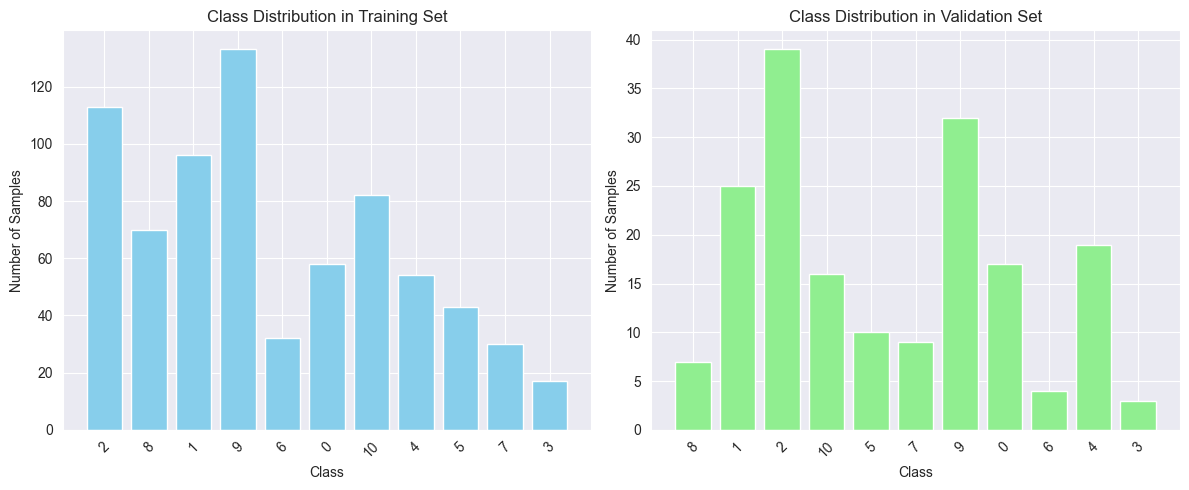

In [88]:
from collections import defaultdict

# Analyze class distribution
def get_class_counts(ds):
    class_names = ds.class_names
    class_counts = defaultdict(int)
    for images, labels in ds:
        labels = labels.numpy()
        for label in labels:
            class_name = class_names[label]
            class_counts[class_name] += 1
    return class_counts

train_class_count = get_class_counts(train_ds)
val_class_count = get_class_counts(validation_ds)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(train_class_count.keys(), train_class_count.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(val_class_count.keys(), val_class_count.values(), color='lightgreen')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Validation Set')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Calculate class weights

In [89]:
total_samples = sum(train_class_count.values())
class_weights = {}

for i, class_name in enumerate(train_class_count):
    class_weights[i] = total_samples / (len(train_class_count) * train_class_count[class_name])

print("\nClass weights:")
print(class_weights)


Class weights:
{0: 0.585679806918745, 1: 0.9454545454545454, 2: 0.6893939393939394, 3: 0.49760765550239233, 4: 2.0681818181818183, 5: 1.141065830721003, 6: 0.8070953436807096, 7: 1.2255892255892256, 8: 1.5391120507399578, 9: 2.206060606060606, 10: 3.893048128342246}


## Split validation dataset

In [90]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_dataset = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

## Split validation dataset

In [91]:
AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## VGG16 model

### Create VGG16 model

In [92]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
    weights='imagenet',
    include_top=False,
)

### Configure VGG16 model

In [93]:
from tensorflow.keras import Model

for layer in vgg16.layers[:-3]: layer.trainable = False

input = vgg16.layers[-1].output

x = tf.keras.layers.Dropout(0.25)(input)
x = tf.keras.layers.Flatten()(x)
output = tf.keras.layers.Dense(len(train_ds.class_names), activation='softmax')(x)

vgg16_model = Model(vgg16.input, output)

### Compile VGG16 model

In [94]:
base_learning_rate = 0.0001
vgg16_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

vgg16_model.summary(show_trainable=True)

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_7 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 224, 224, 64)  │      1,792 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 224, 224, 64)  │     36,928 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 112, 112, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 112, 112, 128) │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 112, 112, 128) │    147,584 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 56, 56, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 56, 56, 256)   │    295,168 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 28, 28, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 28, 28, 512)   │  1,180,160 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 14, 14, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 7, 7, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_11 (Dropout)        │ (None, 7, 7, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_9 (Flatten)         │ (None, 25088)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 11)            │    275,979 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 14,990,667 (57.18 MB)

 Trainable params: 4,995,595 (19.06 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

## Create callbacks

In [95]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint(
        'checkpoints/vgg16_best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

### Train VGG16 model

In [96]:
initial_epochs = 10
vgg16_history = vgg16_model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=validation_ds,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1535 - loss: 30.0669
Epoch 1: val_loss improved from inf to 7.34219, saving model to checkpoints/vgg16_best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.1537 - loss: 29.6964 - val_accuracy: 0.1879 - val_loss: 7.3422 - learning_rate: 1.0000e-04
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2552 - loss: 5.8271
Epoch 2: val_loss improved from 7.34219 to 4.87920, saving model to checkpoints/vgg16_best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - accuracy: 0.2557 - loss: 5.8110 - val_accuracy: 0.2282 - val_loss: 4.8792 - learning_rate: 1.0000e-04
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3574 - loss: 3.2962
Epoch 3: val_loss did not improve from 4.87920
23/23 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - accuracy: 0.3577 - loss: 3.2972 - val_accuracy: 0.1946 - val_loss: 4.9043 - learning_rate: 1.0000e-04
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4455 -

## Plot training results

{'accuracy': [0.15796703100204468, 0.26923078298568726, 0.3640109896659851, 0.4395604431629181, 0.5041208863258362, 0.567307710647583, 0.6098901033401489, 0.6607142686843872, 0.7197802066802979, 0.7362637519836426], 'loss': [21.173885345458984, 5.440033435821533, 3.3200559616088867, 2.419217109680176, 2.0163865089416504, 1.4713220596313477, 1.2593982219696045, 1.0189224481582642, 0.821102499961853, 0.7624266147613525], 'val_accuracy': [0.1879194676876068, 0.2281879186630249, 0.19463087618350983, 0.1879194676876068, 0.19463087618350983, 0.24161073565483093, 0.24161073565483093, 0.23489932715892792, 0.25503355264663696, 0.20805369317531586], 'val_loss': [7.342192649841309, 4.879200458526611, 4.9042863845825195, 4.424192905426025, 4.160491943359375, 4.012681007385254, 3.910876750946045, 4.1928534507751465, 3.976077079772949, 4.2180399894714355], 'learning_rate': [9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05, 9.9999997473

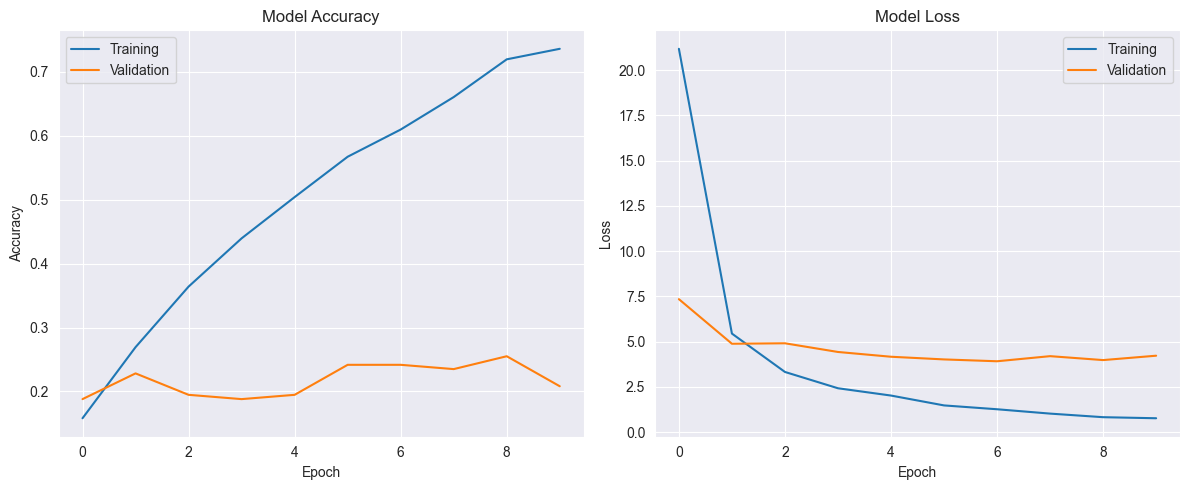

In [97]:
show_model_performance(vgg16_history)

In [98]:
history.history

{'accuracy': [0.10027472674846649,
  0.10439560562372208,
  0.125,
  0.10576923191547394,
  0.10576923191547394,
  0.11950549483299255],
 'loss': [5.402846336364746,
  5.40049409866333,
  5.400391101837158,
  5.400196552276611,
  5.396605968475342,
  5.397340774536133],
 'val_accuracy': [0.0939597338438034,
  0.07382550090551376,
  0.07382550090551376,
  0.08724832534790039,
  0.08053690940141678,
  0.08724832534790039],
 'val_loss': [4.084273815155029,
  4.085661888122559,
  4.08732271194458,
  4.086007595062256,
  4.084824085235596,
  4.0843939781188965]}

## Save trained VGG16 model

In [99]:
vgg16_model.save('models/colposcopy_vgg16.keras')
print("Model saved successfully")

Model saved successfully


## Load other models

In [100]:
custom_model = tf.keras.models.load_model('models/colposcopy_custom.keras')
inception_model = tf.keras.models.load_model('models/colposcopy_model_v2.keras')

In [101]:
# get list of models
models = [custom_model, vgg16_model, inception_model]

## Ensembles

### Configure Concatenated Ensemble

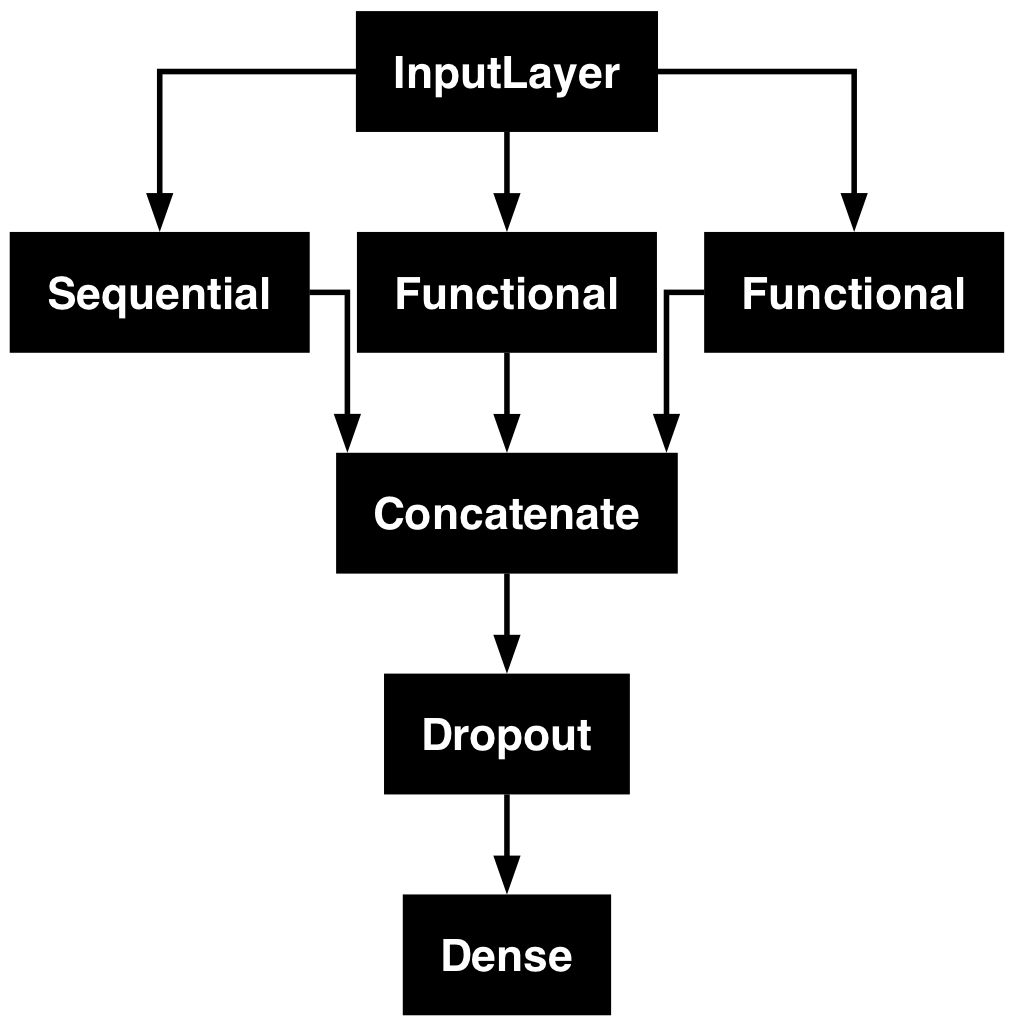

In [102]:
from tensorflow.keras.layers import Concatenate, Input, Dense, Dropout

input = Input(shape=(224, 224, 3), name='input') # input layer

outputs = [model(input) for model in models]

x = Concatenate()(outputs)

x = Dropout(0.5)(x)
output = Dense(len(train_ds.class_names), activation='softmax', name='output')(x) # output layer

conc_model = Model(input, output, name= 'Concatenated_Model')
# show model structure
plot_model(conc_model)

### Compile Concatenated Ensemble model

In [103]:
conc_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

conc_model.summary()

Model: "Concatenated_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 11)        │ 51,612,107 │ input[0][0]       │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_40       │ (None, 11)        │ 14,990,667 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_9        │ (None, 11)        │ 22,857,515 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 33)        │          0 │ sequential_1[0][… │
│ (Concatenate)       │                   │            │ functional_40[0]… │
│                     │                   │            │ functional_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 33)        │          0 │ concatenate_5[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 11)        │        374 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,460,663 (341.27 MB)

 Trainable params: 57,660,823 (219.96 MB)

 Non-trainable params: 31,799,840 (121.31 MB)

### Train Concatenated Ensemble Model

In [104]:
initial_epochs = 10
conc_history = conc_model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=validation_ds,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 361s/step - accuracy: 0.0812 - loss: 5.8941  
Epoch 1: val_loss did not improve from 3.91088
23/23 ━━━━━━━━━━━━━━━━━━━━ 9337s 424s/step - accuracy: 0.0815 - loss: 5.8969 - val_accuracy: 0.1275 - val_loss: 4.1857 - learning_rate: 1.0000e-04
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 599s/step - accuracy: 0.1293 - loss: 5.9186  
Epoch 2: val_loss did not improve from 3.91088
23/23 ━━━━━━━━━━━━━━━━━━━━ 13235s 601s/step - accuracy: 0.1286 - loss: 5.9203 - val_accuracy: 0.1275 - val_loss: 4.1657 - learning_rate: 1.0000e-04
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 652s/step - accuracy: 0.1087 - loss: 5.9807   
Epoch 3: val_loss did not improve from 3.91088
23/23 ━━━━━━━━━━━━━━━━━━━━ 14397s 653s/step - accuracy: 0.1083 - loss: 5.9773 - val_accuracy: 0.1141 - val_loss: 4.1665 - learning_rate: 1.0000e-04
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0953 - loss: 5.8735
Epoch 4: val_loss did not improve from 3.91088
23/23 ━━━━━━━━━━━━━━━━━━

### Save Concatenated Ensemble Model

In [105]:
conc_model.save('models/colposcopy_concat.keras')
print("Model saved successfully")

Model saved successfully


{'accuracy': [0.08653846383094788, 0.11263736337423325, 0.10027472674846649, 0.09203296899795532, 0.09890110045671463, 0.0892857164144516, 0.10164835304021835, 0.11126373708248138, 0.07967033237218857, 0.09065934270620346], 'loss': [5.961612701416016, 5.960813522338867, 5.899963855743408, 5.818283557891846, 5.703296661376953, 5.615106105804443, 5.534124851226807, 5.486575126647949, 5.452154159545898, 5.434645175933838], 'val_accuracy': [0.12751677632331848, 0.12751677632331848, 0.11409395933151245, 0.12080536782741547, 0.1342281848192215, 0.16107381880283356, 0.14765100181102753, 0.12751677632331848, 0.08724832534790039, 0.10738255083560944], 'val_loss': [4.185669422149658, 4.165716171264648, 4.166479110717773, 4.152292728424072, 4.131385803222656, 4.116709232330322, 4.096968650817871, 4.103971004486084, 4.099309921264648, 4.096382141113281], 'learning_rate': [9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05, 9.9999997473

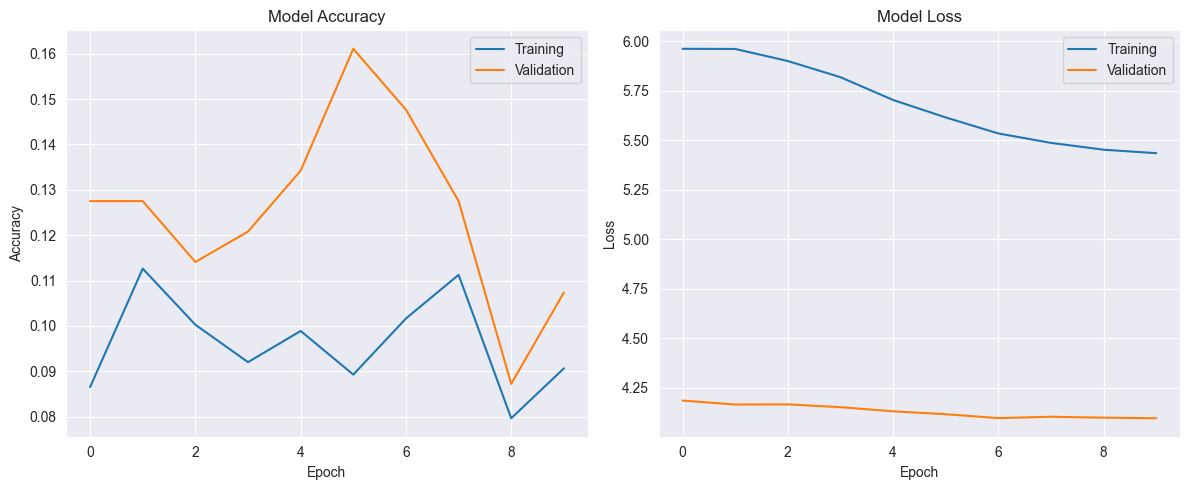

In [106]:
show_model_performance(conc_history)

### Configure Average Ensemble Model

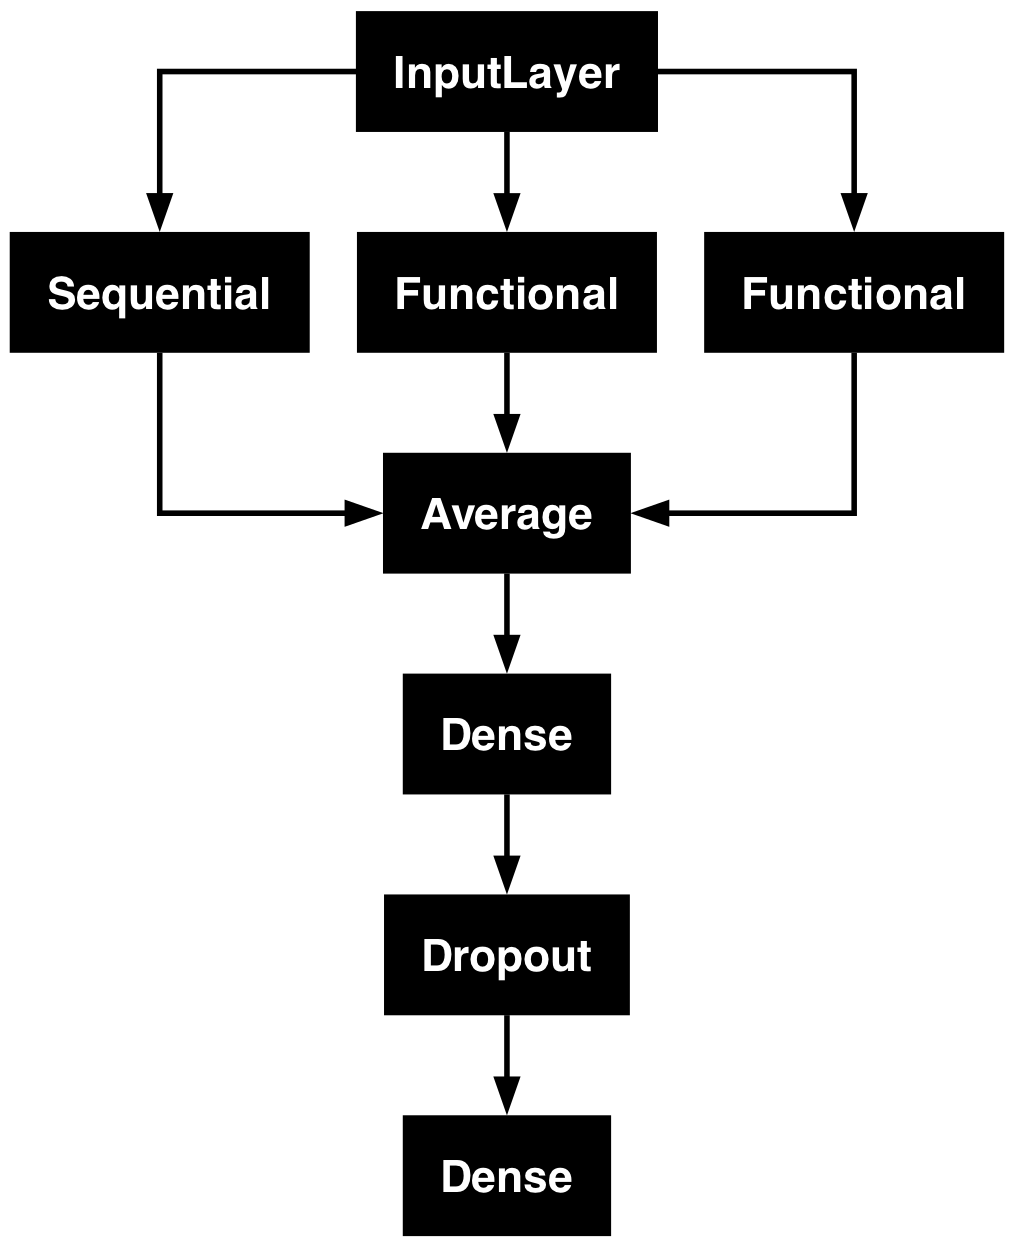

In [107]:
from tensorflow.keras.layers import Average

input = Input(shape=(224, 224, 3), name='input')  # input layer

outputs = [model(input) for model in models]

x = Average()(outputs)

x = Dense(16, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(train_ds.class_names), activation='softmax', name='output')(x) # output layer

avg_model = Model(input, output)

# show model structure
plot_model(avg_model)

### Compile Average Ensemble Model

In [108]:
avg_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

avg_model.summary()

Model: "functional_77"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 11)        │ 51,612,107 │ input[0][0]       │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_40       │ (None, 11)        │ 14,990,667 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_9        │ (None, 11)        │ 22,857,515 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_1 (Average) │ (None, 11)        │          0 │ sequential_1[1][… │
│                     │                   │            │ functional_40[1]… │
│                     │                   │            │ functional_9[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 16)        │        192 │ average_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 16)        │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 11)        │        187 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,460,668 (341.27 MB)

 Trainable params: 57,660,828 (219.96 MB)

 Non-trainable params: 31,799,840 (121.31 MB)

### Train Average Ensemble Model

In [109]:
initial_epochs = 10
avg_history = avg_model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=validation_ds,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.0985 - loss: 5.3736
Epoch 1: val_loss did not improve from 3.91088
23/23 ━━━━━━━━━━━━━━━━━━━━ 240s 10s/step - accuracy: 0.0978 - loss: 5.3755 - val_accuracy: 0.0671 - val_loss: 4.1228 - learning_rate: 1.0000e-04
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.0550 - loss: 5.5550
Epoch 2: val_loss did not improve from 3.91088
23/23 ━━━━━━━━━━━━━━━━━━━━ 201s 9s/step - accuracy: 0.0555 - loss: 5.5494 - val_accuracy: 0.0671 - val_loss: 4.1232 - learning_rate: 1.0000e-04
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0653 - loss: 5.3733
Epoch 3: val_loss did not improve from 3.91088
23/23 ━━━━━━━━━━━━━━━━━━━━ 184s 8s/step - accuracy: 0.0655 - loss: 5.3752 - val_accuracy: 0.0738 - val_loss: 4.1210 - learning_rate: 1.0000e-04
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0827 - loss: 5.4420
Epoch 4: val_loss did not improve from 3.91088
23/23 ━━━━━━━━━━━━━━━━━━━━ 188s 8s/step - accur

In [110]:
avg_model.save('models/colposcopy_avg.keras')
print("Model saved successfully")

Model saved successfully


{'accuracy': [0.08241758495569229, 0.06593406945466995, 0.07005494832992554, 0.07967033237218857, 0.0782967060804367, 0.07554945349693298, 0.07967033237218857, 0.09615384787321091, 0.08791209012269974, 0.08516483753919601], 'loss': [5.419766426086426, 5.4216108322143555, 5.417463302612305, 5.419474124908447, 5.417422294616699, 5.416702747344971, 5.4132208824157715, 5.4098896980285645, 5.405603408813477, 5.409463405609131], 'val_accuracy': [0.06711409240961075, 0.06711409240961075, 0.07382550090551376, 0.0469798669219017, 0.06711409240961075, 0.06040268391370773, 0.05369127541780472, 0.0469798669219017, 0.07382550090551376, 0.06711409240961075], 'val_loss': [4.122777462005615, 4.123154163360596, 4.121004104614258, 4.12233304977417, 4.118075370788574, 4.118255138397217, 4.119349956512451, 4.1184468269348145, 4.1177978515625, 4.121490955352783], 'learning_rate': [9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05, 9.9999997473

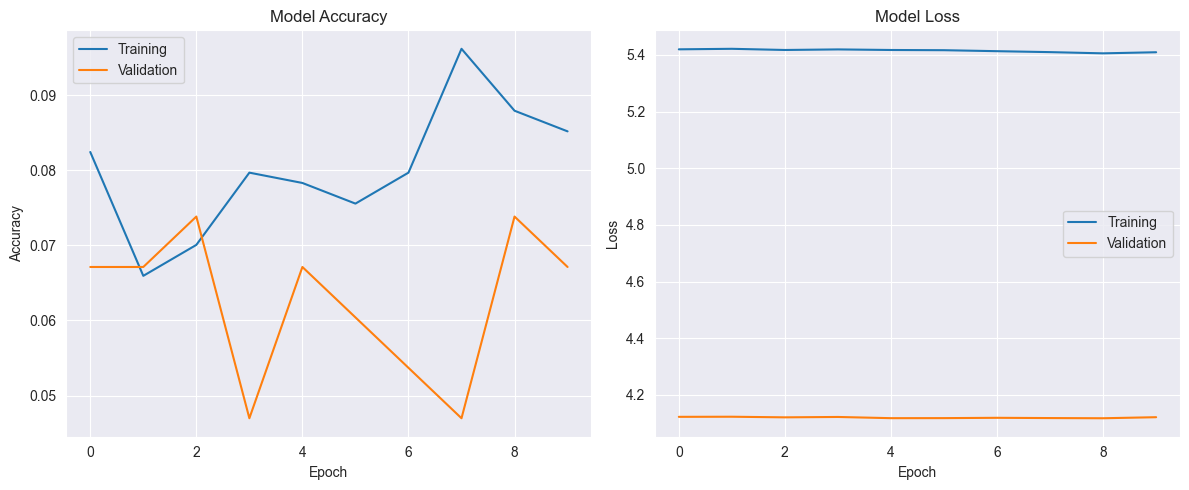

In [111]:
show_model_performance(avg_history)

In [112]:
# function for setting weights

import numpy as np

def weight_init(shape =(1,1,3), weights=[1,2,3], dtype=tf.float32):
    return tf.constant(np.array(weights).reshape(shape), dtype=dtype)

### Implement WeightedAverage layer for Weighted Average Ensemble Model

In [113]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Concatenate

class WeightedAverage(Layer):

    def __init__(self):
        super(WeightedAverage, self).__init__()

    def build(self, input_shape):

        self.W = self.add_weight(
            shape=(1,1,len(input_shape)),
            initializer=weight_init,
            dtype=tf.float32,
            trainable=True
        )

    def call(self, inputs):
        inputs = [tf.expand_dims(i, -1) for i in inputs]
        inputs = Concatenate(axis=-1)(inputs)
        weights = tf.nn.softmax(self.W, axis=-1)

        return tf.reduce_mean(weights*inputs, axis=-1)

### Configure Weighted Average Ensemble Model

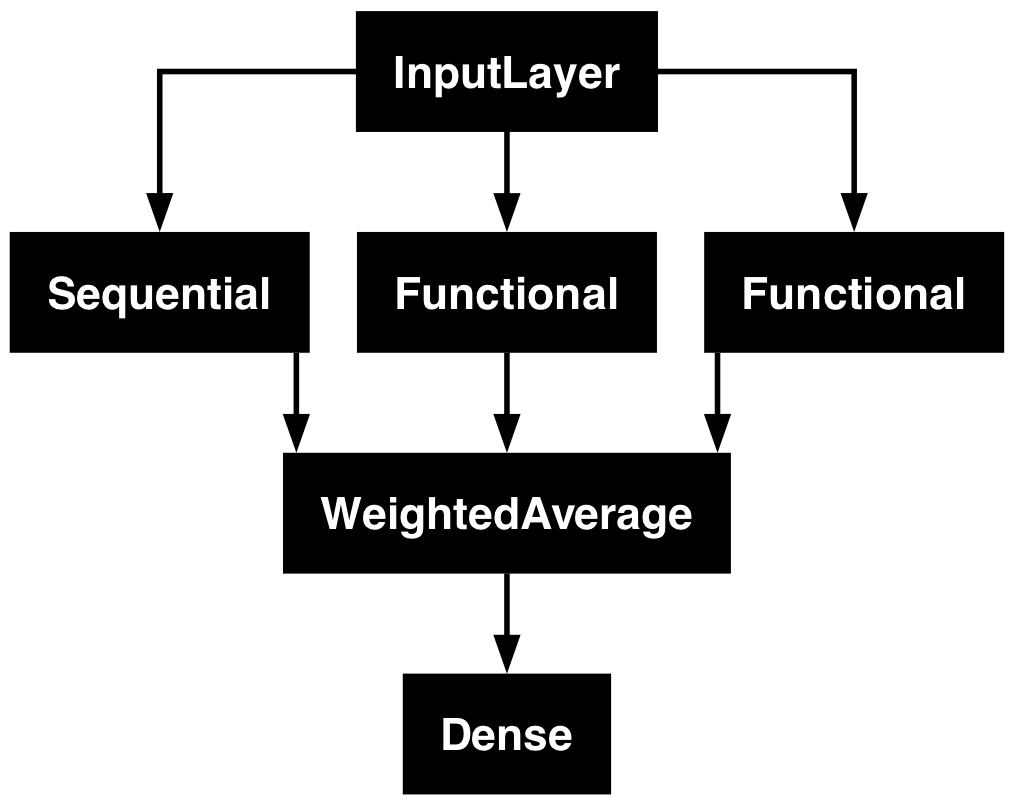

In [114]:
input = Input(shape=(224, 224, 3), name='input')  # input layer

# get output for each input model
outputs = [model(input) for model in models]

# get weighted average of outputs
x = WeightedAverage()(outputs)

output = Dense(len(train_ds.class_names), activation='softmax')(x) # output layer

weighted_avg_model = Model(input, output, name= 'Weighted_AVerage_Model')
# show model structure
plot_model(weighted_avg_model)

### Compile Weighted Average Ensemble Model

In [115]:
weighted_avg_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

weighted_avg_model.summary()

Model: "Weighted_AVerage_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 11)        │ 51,612,107 │ input[0][0]       │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_40       │ (None, 11)        │ 14,990,667 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_9        │ (None, 11)        │ 22,857,515 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_average_1  │ (None, 11)        │          3 │ sequential_1[2][… │
│ (WeightedAverage)   │                   │            │ functional_40[2]… │
│                     │                   │            │ functional_9[2][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 11)        │        132 │ weighted_average… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 89,460,424 (341.26 MB)

 Trainable params: 57,660,584 (219.96 MB)

 Non-trainable params: 31,799,840 (121.31 MB)

### Train Weighted Average Ensemble Model

In [116]:
initial_epochs = 10
weighted_avg_history = weighted_avg_model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=validation_ds,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1454 - loss: 5.4987
Epoch 1: val_loss did not improve from 3.91088
23/23 ━━━━━━━━━━━━━━━━━━━━ 175s 7s/step - accuracy: 0.1450 - loss: 5.4962 - val_accuracy: 0.1745 - val_loss: 4.1166 - learning_rate: 1.0000e-04
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1394 - loss: 5.4911
Epoch 2: val_loss did not improve from 3.91088
23/23 ━━━━━━━━━━━━━━━━━━━━ 168s 7s/step - accuracy: 0.1390 - loss: 5.4889 - val_accuracy: 0.1879 - val_loss: 4.1170 - learning_rate: 1.0000e-04
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1299 - loss: 5.5949
Epoch 3: val_loss did not improve from 3.91088
23/23 ━━━━━━━━━━━━━━━━━━━━ 167s 7s/step - accuracy: 0.1295 - loss: 5.5884 - val_accuracy: 0.1812 - val_loss: 4.1185 - learning_rate: 1.0000e-04
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1497 - loss: 5.4414
Epoch 4: val_loss did not improve from 3.91088
23/23 ━━━━━━━━━━━━━━━━━━━━ 160s 7s/step - accura

In [117]:
weighted_avg_model.save('models/colposcopy_weighted_avg.keras')
print("Model saved successfully")

Model saved successfully


{'accuracy': [0.1359890103340149, 0.12912088632583618, 0.12087912112474442, 0.12362637370824814, 0.12225274741649628, 0.13873626291751862, 0.12774725258350372, 0.12362637370824814, 0.13461539149284363, 0.12362637370824814], 'loss': [5.440253734588623, 5.440443992614746, 5.437901973724365, 5.4361419677734375, 5.436193943023682, 5.433487892150879, 5.430331230163574, 5.431916236877441, 5.429312705993652, 5.428522109985352], 'val_accuracy': [0.17449665069580078, 0.1879194676876068, 0.1812080591917038, 0.1812080591917038, 0.16107381880283356, 0.20805369317531586, 0.20805369317531586, 0.20134228467941284, 0.19463087618350983, 0.1812080591917038], 'val_loss': [4.116628170013428, 4.116973876953125, 4.118456840515137, 4.117682933807373, 4.117647647857666, 4.115782737731934, 4.115146160125732, 4.115816116333008, 4.11467170715332, 4.1148362159729], 'learning_rate': [9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752e-05, 9.999999747378752

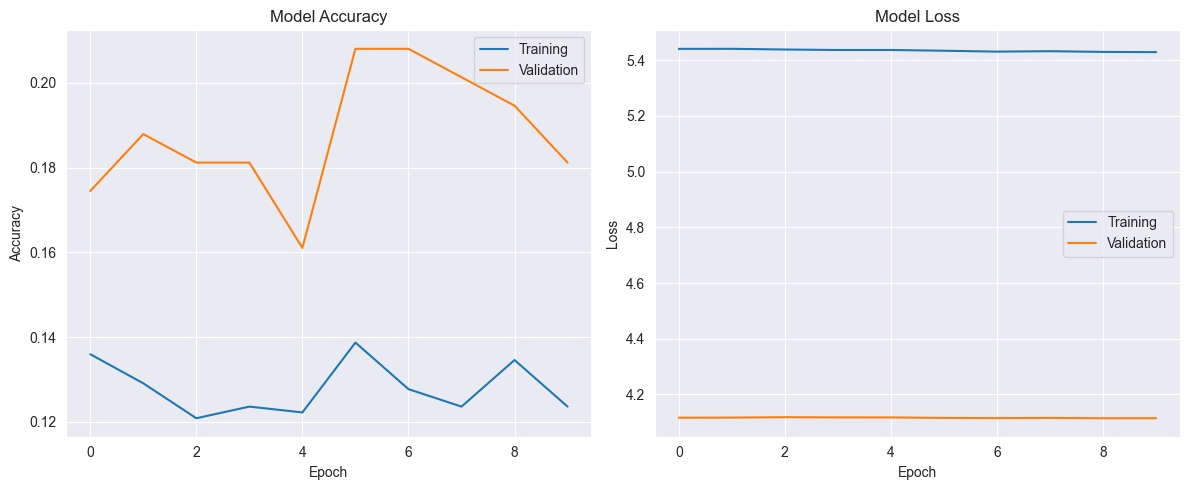

In [118]:
show_model_performance(weighted_avg_history)